Predictors for:

dino CM proportion
dino CM diversity (among other dinos)
CM proportion 
CM diversity (among all other ASVs?)

with env features, with pigment features?
with 18Sv4 and v9, can average results

**Objective: ranking features by how much they reduce sum of squared residuals on base estimators of best performing bagging models.**

### Reading and preprocessing data

In [113]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import BaggingRegressor
%matplotlib inline

In [2]:
#asv_freqs_18Sv4 = pd.read_csv("_out_asv_freqs_18Sv4.tsv", sep = "\t", index_col=0)
#asv_freqs_18Sv9 = pd.read_csv("_out_asv_freqs_18Sv9.tsv", sep = "\t", index_col=0)
#asv_taxo_mft_18Sv4 = pd.read_csv("_out_asv_taxo_mft_18Sv4.tsv", sep = "\t", index_col=0)
#asv_taxo_mft_18Sv9 = pd.read_csv("_out_asv_taxo_mft_18Sv9.tsv", sep = "\t", index_col=0)
env_features_18Sv4 = pd.read_csv("_out_env_features_18Sv4.tsv", sep = "\t", index_col=0)
env_features_18Sv9 = pd.read_csv("_out_env_features_18Sv9.tsv", sep = "\t", index_col=0)
pigment_features_18Sv4 = pd.read_csv("_out_pigment_features_18Sv4.tsv", sep = "\t", index_col=0)
pigment_features_18Sv9 = pd.read_csv("_out_pigment_features_18Sv9.tsv", sep = "\t", index_col=0)
response_features_18Sv4 = pd.read_csv("_out_response_features_18Sv4.tsv", sep = "\t", index_col = 0)
response_features_18Sv9 = pd.read_csv("_out_response_features_18Sv9.tsv", sep = "\t", index_col = 0)

In [3]:
#All expected data types: 3 non-continuous variables
env_features_18Sv4.loc["X201402_086.7_033.0_10"].apply(type)

Cast_Type                    <class 'str'>
Cardinal_Sta                <class 'bool'>
Lat_Dec            <class 'numpy.float64'>
Lon_Dec            <class 'numpy.float64'>
Bottle_Depth       <class 'numpy.float64'>
T_degC             <class 'numpy.float64'>
Salnty             <class 'numpy.float64'>
STheta             <class 'numpy.float64'>
O2ml_L             <class 'numpy.float64'>
PO4ug              <class 'numpy.float64'>
SiO3ug             <class 'numpy.float64'>
NO3ug              <class 'numpy.float64'>
NH3ug              <class 'numpy.float64'>
ChlorA             <class 'numpy.float64'>
Phaeop             <class 'numpy.float64'>
RecInd             <class 'numpy.float64'>
MLD_Sigma          <class 'numpy.float64'>
year               <class 'numpy.float64'>
month              <class 'numpy.float64'>
season                       <class 'str'>
Mins_since_0000    <class 'numpy.float64'>
Name: X201402_086.7_033.0_10, dtype: object

In [4]:
categorical_env_features = env_features_18Sv4.select_dtypes(exclude=[float]).columns.values
numerical_env_features = env_features_18Sv4.select_dtypes(include=[float]).columns.values
categorical_env_features.shape, numerical_env_features.shape, env_features_18Sv4.columns.shape

((3,), (18,), (21,))

In [5]:
season_onehot = pd.get_dummies(env_features_18Sv4["season"], prefix="season")
#nan values are not given a number
season_onehot.loc[['X201511_076.7_080.0_13', 'X201511_076.7_080.0_49',
       'X202007_090.0_090.0_10', 'X202007_090.0_090.0_75']]

,season_fall,season_spring,season_summer,season_winter
X201511_076.7_080.0_13,0,0,0,0
X201511_076.7_080.0_49,0,0,0,0
X202007_090.0_090.0_10,0,0,0,0
X202007_090.0_090.0_75,0,0,0,0


In [6]:
env_features_18Sv4.loc[[type(env_features_18Sv4.loc[index, "season"]) == float for index in env_features_18Sv4.index]].index

Index(['X201511_076.7_080.0_13', 'X201511_076.7_080.0_49',
       'X202007_090.0_090.0_10', 'X202007_090.0_090.0_75'],
      dtype='object')

In [7]:
env_features_18Sv4["season"].values.reshape(-1,1)

array([['winter'],
       ['winter'],
       ['winter'],
       ...,
       ['fall'],
       ['fall'],
       ['fall']], dtype=object)

In [8]:
#removes all rows with nan values, 206 rows lost
env_features_18Sv4.dropna().shape, env_features_18Sv4.shape

((938, 21), (1144, 21))

In [9]:
#one hot encoder counts nan as a distinct value
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
encoded_sparse_matrix = encoder.fit_transform(env_features_18Sv4["season"].values.reshape(-1,1))
encoded_sparse_matrix.todense()

matrix([[0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0.],
        ...,
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.]])

### Filtering rows with NA values & one-hot for categorical variables

Scikit learn's binary decision trees cannot handle missing values

In [10]:
categorical_env_features

array(['Cast_Type', 'Cardinal_Sta', 'season'], dtype=object)

In [24]:
#only removes the rows with nan values on categorical variables
env_features_18Sv4_filtered = env_features_18Sv4.dropna()
env_features_18Sv9_filtered = env_features_18Sv9.dropna()
env_features_18Sv4_filtered.shape, env_features_18Sv9_filtered.shape

((938, 21), (1263, 21))

In [25]:
X_18Sv4 = env_features_18Sv4_filtered[numerical_env_features].join(
    pd.get_dummies(env_features_18Sv4_filtered["Cast_Type"], prefix="Cast_Type")).join(
    pd.get_dummies(env_features_18Sv4_filtered["Cardinal_Sta"], prefix="Cardinal")).join(
    pd.get_dummies(env_features_18Sv4_filtered["season"], prefix="season"))

X_18Sv9 = env_features_18Sv9_filtered[numerical_env_features].join(
    pd.get_dummies(env_features_18Sv9_filtered["Cast_Type"], prefix="Cast_Type")).join(
    pd.get_dummies(env_features_18Sv9_filtered["Cardinal_Sta"], prefix="Cardinal")).join(
    pd.get_dummies(env_features_18Sv9_filtered["season"], prefix="season"))

In [26]:
X_18Sv4

,Lat_Dec,Lon_Dec,Bottle_Depth,T_degC,Salnty,STheta,O2ml_L,PO4ug,SiO3ug,NO3ug,...,Mins_since_0000,Cast_Type_Prodo,Cast_Type_Ros,Cast_Type_Ross,Cardinal_False,Cardinal_True,season_fall,season_spring,season_summer,season_winter
X201402_086.7_033.0_10,33.88950,-118.49250,10.0,14.652000,33.495701,24.888700,5.661,0.48,4.46,1.80,...,1161.0,1,0,0,1,0,0,0,0,1
X201402_086.7_033.0_22,33.88950,-118.49250,22.0,14.619000,33.494900,24.895889,5.624,0.50,4.59,1.80,...,1161.0,1,0,0,1,0,0,0,0,1
X201402_090.0_037.0_10,33.18017,-118.39332,10.0,15.544000,33.530701,24.721359,5.822,0.34,2.54,0.00,...,122.0,0,1,0,0,1,0,0,0,1
X201402_090.0_037.0_30,33.18017,-118.39332,30.0,14.020000,33.443100,24.982420,5.748,0.48,3.31,1.40,...,122.0,0,1,0,0,1,0,0,0,1
X201402_090.0_053.0_10,32.65117,-119.48417,10.0,14.460000,33.290100,24.770920,5.897,0.37,2.37,0.10,...,600.0,0,1,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
X201911_093.3_045.0_30,32.34787,-118.55243,30.0,14.167000,33.521000,25.011959,5.604,0.41,3.05,1.46,...,1115.0,1,0,0,1,0,1,0,0,0
X201911_093.3_080.0_10,31.18013,-120.91923,10.0,18.037001,33.329899,23.986210,5.531,0.23,1.34,0.00,...,1077.0,1,0,0,1,0,1,0,0,0
X201911_093.3_080.0_50,31.18013,-120.91923,50.0,16.039000,33.308998,24.442770,5.806,0.24,1.13,0.00,...,1077.0,1,0,0,1,0,1,0,0,0
X201911_093.3_120.0_113,29.84620,-123.58647,113.0,14.795000,33.705601,25.026501,5.569,0.27,2.21,0.10,...,995.0,1,0,0,1,0,1,0,0,0


In [27]:
X_18Sv9

,Lat_Dec,Lon_Dec,Bottle_Depth,T_degC,Salnty,STheta,O2ml_L,PO4ug,SiO3ug,NO3ug,...,Mins_since_0000,Cast_Type_Prodo,Cast_Type_Ros,Cast_Type_Ross,Cardinal_False,Cardinal_True,season_fall,season_spring,season_summer,season_winter
X201402_086.7_033.0_10,33.88950,-118.49250,10.0,14.652000,33.495701,24.888700,5.661,0.48,4.46,1.80,...,1161.0,1,0,0,1,0,0,0,0,1
X201402_086.7_033.0_22,33.88950,-118.49250,22.0,14.619000,33.494900,24.895889,5.624,0.50,4.59,1.80,...,1161.0,1,0,0,1,0,0,0,0,1
X201402_090.0_037.0_10,33.18017,-118.39332,10.0,15.544000,33.530701,24.721359,5.822,0.34,2.54,0.00,...,122.0,0,1,0,0,1,0,0,0,1
X201402_090.0_037.0_30,33.18017,-118.39332,30.0,14.020000,33.443100,24.982420,5.748,0.48,3.31,1.40,...,122.0,0,1,0,0,1,0,0,0,1
X201402_090.0_053.0_10,32.65117,-119.48417,10.0,14.460000,33.290100,24.770920,5.897,0.37,2.37,0.10,...,600.0,0,1,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
X201611_093.3_026.7_24_S,32.95627,-117.30493,25.0,14.585000,33.258202,24.720739,5.571,0.48,3.71,1.52,...,1194.0,1,0,0,1,0,1,0,0,0
X201611_093.3_045.0_33_S,32.34653,-118.55438,33.0,16.045000,33.313301,24.443510,5.801,0.36,2.66,0.14,...,1246.0,1,0,0,1,0,1,0,0,0
X201611_093.3_045.0_9_S,32.34653,-118.55438,9.0,19.218000,33.499699,23.821510,5.394,0.25,1.96,0.04,...,1246.0,1,0,0,1,0,1,0,0,0
X201611_093.3_070.0_12_S,31.52068,-120.24880,12.0,17.959000,33.379299,24.043190,5.501,0.26,1.28,0.00,...,989.0,1,0,0,1,0,1,0,0,0


### Model 1: Within sample dino CM percent

per sample dino CM proportion

per sample dino CM diversity (among other dinos)

per sample CM proportion 

per sample CM diversity (among all other ASVs?)

In [28]:
dino_CM_percent_18Sv4 = response_features_18Sv4.loc[X_18Sv4.index,"within_sample_dino_CM_percent"]
dino_CM_percent_18Sv9 = response_features_18Sv9.loc[X_18Sv9.index,"within_sample_dino_CM_percent"]

In [29]:
dino_CM_percent_18Sv4

X201402_086.7_033.0_10     1.559030
X201402_086.7_033.0_22     1.085602
X201402_090.0_037.0_10     0.739182
X201402_090.0_037.0_30     0.305318
X201402_090.0_053.0_10     0.420431
                             ...   
X201911_093.3_045.0_30     0.796762
X201911_093.3_080.0_10     1.308038
X201911_093.3_080.0_50     0.084861
X201911_093.3_120.0_113    0.020103
X201911_093.3_120.0_17     0.822397
Name: within_sample_dino_CM_percent, Length: 938, dtype: float64

**Train test split**

There's 1 feature dataset and 2 response datasets, we're going to use ~20% of the features to test later
Make a selection vector and use it to make Xtrain, Xtest, y1train, y1test, y2train, y2test?

Problem! Say I make an ensemble model fitted to 80% of either response vector. If we're starting with the premise that v4 and v9 offer very different views... which one is actually correct? is the test set just going to be "every single observation twice, except associated with two different responses each time?" what would accuracy on something like that even mean?

it would be one thing to have 2 models where ASV data are predictors and something biogeochemical is the response (bowman)...

In [85]:
X_train_18Sv4, X_test_18Sv4, y_train_18Sv4, y_test_18Sv4 = train_test_split(X_18Sv4, dino_CM_percent_18Sv4,
                                                                           test_size = 0.2, random_state = 0) 

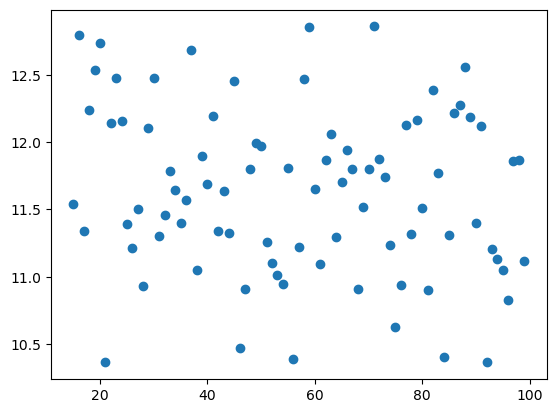

In [91]:
#possibilities: too many of the large percents end up in test set and train can't predict them,
#low train error & high test error
def cv(X, y, B, folds):
    cv_index = np.random.randint(0, folds, X.index.size)
    mse_per_fold = []
    for fold in range(folds):
        model = BaggingRegressor(
            base_estimator=DecisionTreeRegressor(
                #max_depth=6
            ), #see if we get better results by stopping splits earlier
            n_estimators = B, #tune this
            #oob_score=True
        ).fit(X.loc[cv_index != fold], y.loc[cv_index != fold])
        mse = np.mean(
            (model.predict(X.loc[cv_index == fold]) - y.loc[cv_index == fold]) ** 2
        )
        mse_per_fold.append(mse)
    return np.mean(mse_per_fold)

B_range = [i for i in range(15, 100)]
cv_errors = [cv(folds=10, X=X_train_18Sv4, y=y_train_18Sv4, B = B) for B in B_range]
fig, ax = plt.subplots()
ax.scatter(x=B_range, y=cv_errors)
plt.show()

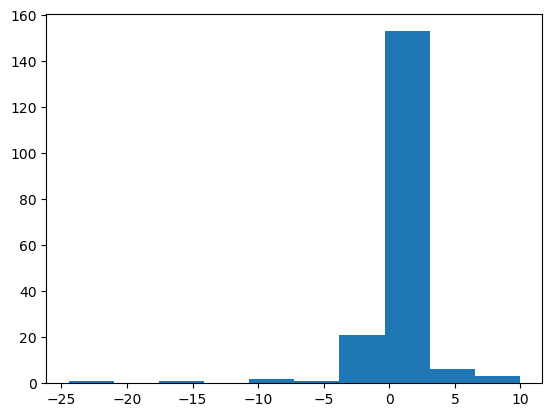

8.044694607605416

In [94]:
model_env_dino_CM_percent_18Sv4 = BaggingRegressor(
    #estimator=DecisionTreeRegressor(), #see if we get better results by stopping splits earlier
    n_estimators = 100, #tune this
    #oob_score=True,
    random_state=0
).fit(X_train_18Sv4, y_train_18Sv4)

residuals = (model_env_dino_CM_percent_18Sv4.predict(X_test_18Sv4) - y_test_18Sv4)
fig, ax = plt.subplots()
ax.hist(residuals)
plt.show()

np.mean(residuals ** 2)# ** 0.5

In [102]:
X_train_18Sv9, X_test_18Sv9, y_train_18Sv9, y_test_18Sv9 = train_test_split(X_18Sv9, dino_CM_percent_18Sv9,
                                                                           test_size = 0.2, random_state = 0) 

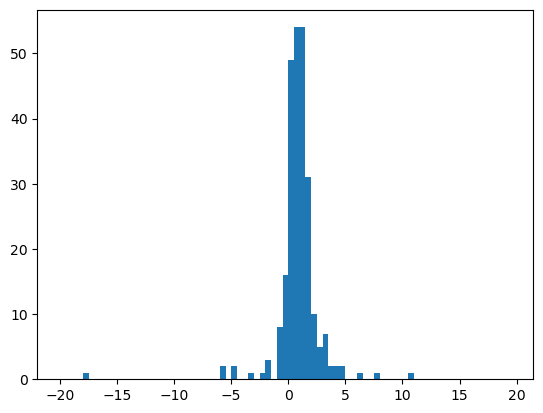

(4.577620569429739, 0.051786810464016134)

In [116]:
model_env_dino_CM_percent_18Sv9 = BaggingRegressor(
    base_estimator=DecisionTreeRegressor(max_depth=6), #see if we get better results by stopping splits earlier
    n_estimators = 20, #tune this
    #oob_score=True,
    random_state=0
).fit(X_train_18Sv9, y_train_18Sv9)
np.mean((model_env_dino_CM_percent_18Sv9.predict(X_test_18Sv9) - y_test_18Sv9) ** 2)# ** 0.5

y_pred_18Sv9 = model_env_dino_CM_percent_18Sv4.predict(X_test_18Sv9)
residuals = (y_test_18Sv9 - y_pred_18Sv9)
fig, ax = plt.subplots()
ax.hist(residuals, bins=np.arange(-20,20,0.5))
plt.show()

np.mean(residuals ** 2), np.min(y_pred_18Sv9) #wouldn't expect to go below 0

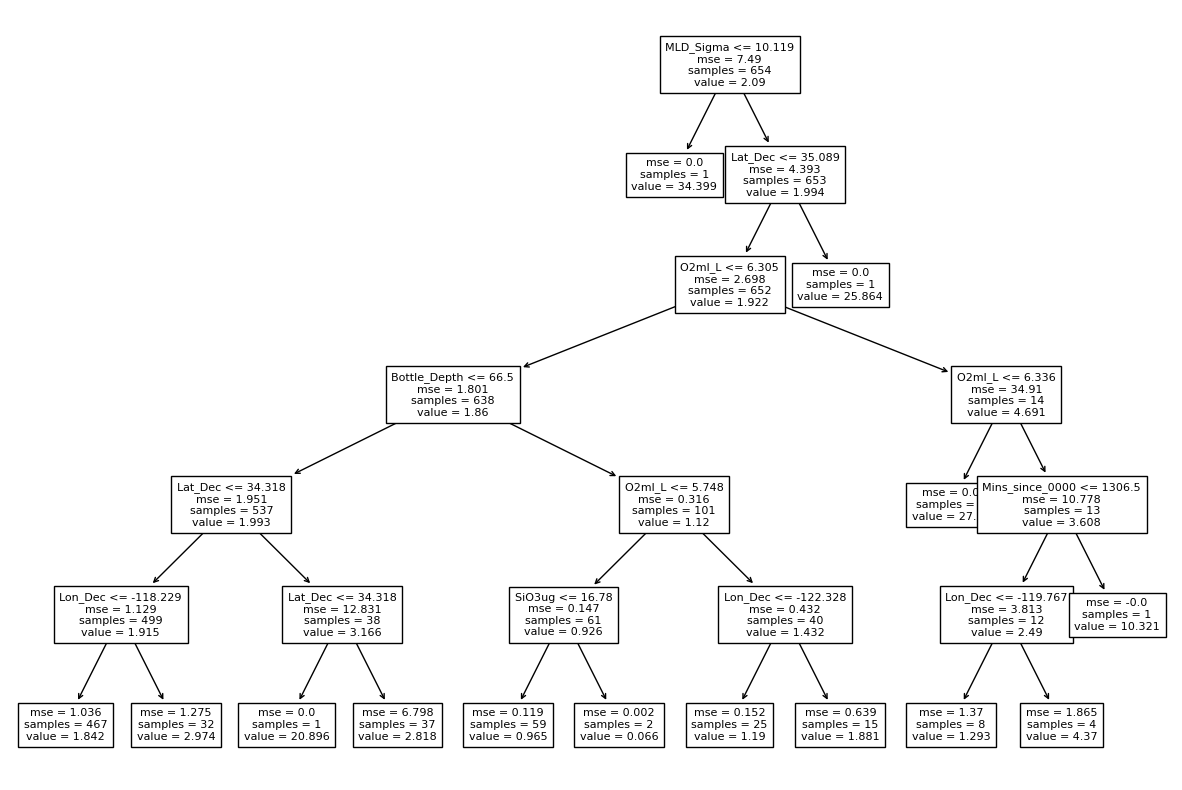

In [151]:
plt.figure(figsize=(15,10))
plot_tree(model_env_dino_CM_percent_18Sv9.estimators_[3],feature_names=X_train_18Sv9.columns, fontsize=8)
plt.show()

In [118]:
#need a way to access every tree and every split, and count the involvement of each feature
#we can see that every estimator was working from the same set of features
model_env_dino_CM_percent_18Sv9.estimators_features_

[array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25

In [145]:
for estimator in model_env_dino_CM_percent_18Sv9.estimators_:
    #binary tree stored as parallel arrays, each array holds info about ith node (internal or leaf)
    tree = estimator.tree_
    print(tree)
    #every -2 represents a leaf node
    #print(tree.feature)
    #mse is the impurity measure for regression
    #print(tree.impurity)

#a good split will decrease the amount of impurity? not necessarily. might split into a large low mse node
#and a small, high mse node. so they have to be weighted?
#MSE decrease = MSE_parent - sum(MSE_children)
#does not need to be calculated when "MSE parent" would be a leaf node.

In [154]:
total_se_decrease=[0] * X_train_18Sv4.columns.size

for estimator in model_env_dino_CM_percent_18Sv9.estimators_:
    tree = estimator.tree_
    for node_id in range(len(tree.feature)):
        #if this node is a leaf, skip
        feature_id = tree.feature[node_id]
        if feature_id < 0:
            continue
        #if node is not a leaf, find MSE_parent - sum(MSE_children)
        left_child_id = tree.children_left[node_id]
        right_child_id = tree.children_right[node_id]
        SE_parent = tree.impurity[node_id] * tree.n_node_samples[node_id]
        SE_children = (tree.impurity[left_child_id] * tree.n_node_samples[left_child_id]) \
                    + (tree.impurity[right_child_id] * tree.n_node_samples[right_child_id])
        #seems like we can't count on this, a split will choose a bad option even if it's "best"
        #assert(SE_parent >= SE_children)
        #if SE_parent < SE_children:
        #    print(SE_parent, tree.impurity[node_id], tree.n_node_samples[node_id])
        #    print(SE_children, tree.impurity[left_child_id], tree.n_node_samples[left_child_id])
        #    print(tree.impurity[right_child_id], tree.n_node_samples[right_child_id])
        #    print(tree)
        #    assert(False)
        #attribute the MSE decrease to the feature that this node splits on
        total_se_decrease[feature_id] += (SE_parent - SE_children)
        
pd.Series(total_se_decrease, index=X_train_18Sv9.columns).sort_values(ascending=False)

MLD_Sigma          23662.745874
Lat_Dec             7818.313196
ChlorA              4716.754454
Bottle_Depth        3418.963555
Lon_Dec             3317.360293
STheta              2095.560672
O2ml_L              1537.447965
Mins_since_0000     1515.577786
Cast_Type_Ross      1173.049365
PO4ug                949.011137
season_spring        935.796555
month                900.827892
Phaeop               634.809242
NO3ug                561.131028
T_degC               418.110045
season_summer        208.457036
NH3ug                180.469912
year                 146.402753
Salnty                94.634361
SiO3ug                45.111192
season_winter          3.135830
Cardinal_True          1.545901
Cast_Type_Prodo        0.141530
Cardinal_False         0.000000
season_fall            0.000000
Cast_Type_Ros          0.000000
RecInd                 0.000000
dtype: float64